# Homework 2 - IS-Academia

In [1]:
import requests as rq
from bs4 import BeautifulSoup as bfs
import numpy as np
import pandas as pd
import collections
import os
%matplotlib inline
import matplotlib.pyplot as plt
from dateutil import relativedelta
import scipy.stats as stats
import math

<b><span style="color:red">GENERAL NOTES:</span>

- We are not EPFL students and, thus, we don't know the exact rules of school. All the assumptions made in this Notebook can differ a bit from the functioning here at EPFL, but we tried to remain realistic regarding the obtained data.
- As French is used by IS-Academia when returning data, we deliberately kept French when displaying data. Additionnaly, and still for the same reason, newly added columns are displayed in French. However, all comments are written in English.
- In this Notebook, we propose a way to store the collected data from server. We want to draw the attention of reader to the fact that, due to instability of IS-Academia, and among multiple other factors, it is possible that the data differ between two fetchs. However, global results displayed in this Notebook are not affected by these possible differencies. Finally, we provide, by default, a copy of fetched data in the folder 'Data'. To fetch again the data, simply delete the entire folder and execute again the Notebook's cells.</b>

# Question 1 - Bachelor

<b>Obtain all the data for the Bachelor students, starting from 2007. Keep only the students for which you have an entry for both Bachelor semestre 1 and Bachelor semestre 6. Compute how many months it took each student to go from the first to the sixth semester. Partition the data between male and female students, and compute the average -- is the difference in average statistically significant?</b>

Firstly, we define some constants that will be usefull for all questions. The two URLs have been found using Postman Interceptor.

In [2]:
DATA_FOLDER = 'Data/' # Name of folder which will contain all data fetched from IS-Academia
DATA_URL = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html' # URL of data
FILTER_URL = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247' # URL of online form

## Getting params

In order to get all students data, we need to get all available parameters to fetch the database by the REST API. To do so, we begin by requesting all the sections displayed in the `select` lists of the form. Then, for each option, we extract the human-readable name and its corresponding value.

In [3]:
filters_page = rq.get(FILTER_URL) # Retrieving content of online form
filters = bfs(filters_page.text, 'html.parser')
selects = filters.findAll('select') # Filter the content by selecting the 'select' HTML tags

available_params = collections.defaultdict(dict)

for select in selects:    
    options = collections.defaultdict(list)
    
    for option in select.findAll('option'):
        if option.attrs['value'] != 'null':
            options[option.text] = option.attrs['value']
        
    available_params[select.attrs['name']] = options
  
available_params

defaultdict(dict,
            {'ww_x_HIVERETE': defaultdict(list,
                         {"Semestre d'automne": '2936286',
                          'Semestre de printemps': '2936295'}),
             'ww_x_PERIODE_ACAD': defaultdict(list,
                         {'2007-2008': '978181',
                          '2008-2009': '978187',
                          '2009-2010': '978195',
                          '2010-2011': '39486325',
                          '2011-2012': '123455150',
                          '2012-2013': '123456101',
                          '2013-2014': '213637754',
                          '2014-2015': '213637922',
                          '2015-2016': '213638028',
                          '2016-2017': '355925344'}),
             'ww_x_PERIODE_PEDAGO': defaultdict(list,
                         {'Bachelor semestre 1': '249108',
                          'Bachelor semestre 2': '249114',
                          'Bachelor semestre 3': '942155',
                

### Making params names readable

Even if we have all parameters, they are still not easy to read.

In order to improve readability, we made the choice to directly check the source code of the HTML page and do the mapping as there are very few `select` boxes (i.e. it is faster than extracting the information directly with Python).

Every constant represents a parameter name. In addition, we define a dictionary of default params used for all requests we will send.

In [4]:
SECTION_PARAM = 'ww_x_UNITE_ACAD' # Example: 'Informatique' => Computer Sciences
YEAR_PARAM = 'ww_x_PERIODE_ACAD' # Example: '2016-2017'
SEMESTER_PARAM = 'ww_x_PERIODE_PEDAGO' # Example: 'Bachelor semestre 1' => Bachelor semester 1
TYPE_PARAM = 'ww_x_HIVERETE' # Example: 'Semestre d'automne' => Fall semester

DEFAULT_PARAMS = {
    'ww_x_GPS' : '-1',
    'ww_i_reportModel' : '133685247',
    'ww_i_reportModelXsl' : '133685270',
}

section_codes = available_params[SECTION_PARAM]
year_codes = available_params[YEAR_PARAM]
semester_codes = available_params[SEMESTER_PARAM]
type_codes = available_params[TYPE_PARAM]

## Fetching data

Firstly, we make a function that returns a single DataFrame from the HTML table extracted from a requested page.

We also try to get columns from table header. Note that in our case, all tables have two header rows ; the first one is the title of the table and the second one is the column name.

Then, we fetch all rows to convert them into a single Serie (list of column values in this row).

Finally, we combine columns' names and series in a new DataFrame.

In [5]:
def html_page_to_dataframe(page):
    '''
    This functions converts a HTML table (of a given HTML page 'page' passed as parameter) to a pandas DataFrame.
    '''
    soup = bfs(page.text, 'html.parser')
    table = soup.find('table')
    
    # Retrieving columns' names, skip the first column that shows the section and year
    columns = [column.text for column in table.find_all('th')[1:]]
    
    series = []
    
    # Fetching all rows and store them in a Serie, skip the two first rows that represent header
    for row in table.find_all('tr')[2:]:
        serie = []
        
        # Fetching all columns, skip the last one that is not in the header (badly structered html table)
        for col in row.find_all('td')[:-1]:
            serie.append(col.text)
        series.append(serie)

    # Creating a dataframe from the columns and series' variables
    df = pd.DataFrame(series)
    df.columns = columns
    
    return df

Now, we are able to request an IS-Academia page containing the data tables of students in a specific section, year and semester.

<b>Important note: We choose to store all data to prevent doing multiple requests to IS-Academia server. To do so, we use pickle to serialize all data. Make sure python has full read/write access in the folder containing the current Notebook.</b>

In [6]:
# We first create the directory Data if it not exists
if not os.path.exists('Data'):
    os.makedirs(DATA_FOLDER)

# We focus only on data of students in Bachelor and Master
bachelor_master_semester_codes = {}
for section_name in semester_codes:
    if section_name.startswith('Bachelor semestre') or section_name.startswith('Master semestre') or section_name.startswith('Projet Master'):
            bachelor_master_semester_codes[section_name] = semester_codes[section_name]

print('Start fetching data from ' + DATA_URL)

# For each available codes in the year select box
for year_name, year_code in year_codes.items():

    # For each codes from Master and Bachelor sections
    for semester_name, semester_code in bachelor_master_semester_codes.items():
        
        print('\tFetching data for ' + year_name + ' ' + semester_name + '\t: ', end="", flush=True)

        file_path = DATA_FOLDER + year_name + ' ' + semester_name
        
        # If the file already exists, we do nothing
        if not os.path.exists(file_path):
            
            # Definition of set of params used for the next request to be sent
            params = {
                SECTION_PARAM : section_codes['Informatique'],
                YEAR_PARAM : year_code,
                SEMESTER_PARAM : semester_code,
                TYPE_PARAM : 'null',
                **DEFAULT_PARAMS
            }

            try:
                # We get a DataFrame from HTML table
                data = html_page_to_dataframe(rq.get(DATA_URL, params))

                if data.empty:
                    print('No data')
                    
                else:
                    # We store data in binary file with pickle in the Data folder
                    data.to_pickle(file_path)
                    print('Stored in ' + file_path)

            except ValueError:
                print('Unable to get data from ' + DATA_URL + ' with following params:')
                for key, value in params.items():
                    print('\t\t' + key + ': ' + value)
                break

        else:
            print('Already stored in ' + file_path)

print('Fetching data done. See ' + DATA_FOLDER + ' folder.')

Start fetching data from http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html
	Fetching data for 2015-2016 Master semestre 2	: Already stored in Data/2015-2016 Master semestre 2
	Fetching data for 2015-2016 Bachelor semestre 3	: Already stored in Data/2015-2016 Bachelor semestre 3
	Fetching data for 2015-2016 Bachelor semestre 4	: Already stored in Data/2015-2016 Bachelor semestre 4
	Fetching data for 2015-2016 Bachelor semestre 6	: Already stored in Data/2015-2016 Bachelor semestre 6
	Fetching data for 2015-2016 Bachelor semestre 5	: Already stored in Data/2015-2016 Bachelor semestre 5
	Fetching data for 2015-2016 Bachelor semestre 5b	: No data
	Fetching data for 2015-2016 Master semestre 4	: No data
	Fetching data for 2015-2016 Projet Master automne	: Already stored in Data/2015-2016 Projet Master automne
	Fetching data for 2015-2016 Bachelor semestre 2	: Already stored in Data/2015-2016 Bachelor semestre 2
	Fetching data for 2015-2016 Bachelor semestre 1	: Already stored in Data

> Note: A problem has been detected with "2008-2009 Bachelor semestre 3" and "2007-2008 Bachelor semestre 3" options ; multiple table were found (two entries instead of one). As we have only two errors, we don't do anything at this time. If we need these data, we will do the request manually.

### Analysing Bachelor data

We can notice that the data related to students in Bachelor 5b and Bachelor 6b are empty in Computer Science section.

From now, we assume the following assumptions:
 - 1) a bachelor student starts at the semester 1 and finishes at the semester 6 or 5 (in case of the student has failed the semester 5 but not the semester6);
 - 2) a semester lasts 6 months;
 - 3) odd semesters correspond to the fall period and even semesters correspond to the spring semesters.
 
So, we need to get relevant data (regarding the assumptions) from files and concat them together in a single DataFrame.

We firstly concat every data of one section in a DataFrame like this:

In [7]:
def retrieve_dataframes(semester_codes, extra_compute, data_folder=DATA_FOLDER):
    '''
    This function retrieves data from files and returns a table of DataFrames for every given section.
    
    Parameters:
        semester_codes: dict (section name : section code) that the function will retrieve
        extra_compute: extra function executed for every year of a specific section (params: data for this year, semester name and year name)
        data_folder: the data folder where data is stored (by default DATA_FOLDER constant)
    '''
    # Variable contains a list of DataFrames associated to a semester_name
    dataframes = collections.defaultdict(pd.DataFrame)

    for semester_name, semester_code in semester_codes.items():

        print('Compute for ' + semester_name)

        # Variable contains a list of DataFrames related to a specific semester
        for year_name, year_code in year_codes.items():

            file_path = data_folder + year_name + ' ' + semester_name

            if os.path.exists(file_path):

                # We get a DataFrame from a HTML table
                data_per_year = pd.read_pickle(file_path)

                extra_compute(data_per_year, semester_name, year_name)

                # We add the result to the initial DataFrame
                dataframes[semester_name] =  pd.concat([dataframes[semester_name], data_per_year])
                
    return dataframes

In [8]:
# We only select semesters 1, 5, 6 in Bachelor section
bachelor_semester_codes = {}
for section_name in semester_codes:
    if section_name.startswith('Bachelor semestre') and section_name.endswith(tuple(['1', '5', '6'])):
        bachelor_semester_codes[section_name] = semester_codes[section_name]

# This is the 'extra_compute' function given to the previous function
def bachelor_append_year(data_per_year, semester_name, year_name):
    '''
    This function appends a column with the beginning date of the considered semester.
    By convention: for odd semesters, beginning date is 08/01. For even semesters, it is 02/01.
    '''
    if semester_name.endswith('1') or semester_name.endswith('5'):
        begin_date = year_name.split('-')[0] + '-08-01'
    else:
        begin_date = year_name.split('-')[1] + '-02-01'
    data_per_year[semester_name] = pd.to_datetime(begin_date) 

bachelor_dataframes = retrieve_dataframes(bachelor_semester_codes, bachelor_append_year)

Compute for Bachelor semestre 1
Compute for Bachelor semestre 5
Compute for Bachelor semestre 6


## Visualising and cleaning data

Now, we can try to visualise and clean data. Let's display of DataFrame corresponding to 'Bachelor semestre 1', 'Bachelor semestre 5' and 'Bachelor semestre 6' to have an idea of which kind of data we will manipulate.

In [9]:
bachelor_data_semester1 = bachelor_dataframes['Bachelor semestre 1'].copy()
bachelor_data_semester1.head()

,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,No Sciper,Bachelor semestre 1
0,Monsieur,Abbey Alexandre,,,,,,Présent,,,235688,2015-08-01
1,Madame,Abboud Magaly,,,,,,Présent,,,249344,2015-08-01
2,Monsieur,Ahmed Fares,,,,,,Présent,,,246443,2015-08-01
3,Monsieur,Alder Jean-Marie René,,,,,,Présent,,,259105,2015-08-01
4,Madame,Amirthalingam Ajantha,,,,,,Présent,,,262227,2015-08-01


In [10]:
bachelor_data_semester5 = bachelor_dataframes['Bachelor semestre 5'].copy()
bachelor_data_semester5.head()

,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,No Sciper,Bachelor semestre 5
0,Monsieur,Aiulfi Loris Sandro,,,,,,Congé,,,202293,2015-08-01
1,Monsieur,Alfonso Peterssen Alfonso,,,,6 - Visual computing,,Présent,,,228219,2015-08-01
2,Monsieur,Alonso Seisdedos Florian,,,,,,Présent,,,215576,2015-08-01
3,Monsieur,Angerand Grégoire Georges Jacques,,,,,,Présent,,,212464,2015-08-01
4,Monsieur,Anongba Varela Dario Abougnan,,,,7 - Biocomputing,,Présent,,,226371,2015-08-01


In [11]:
bachelor_data_semester6 = bachelor_dataframes['Bachelor semestre 6'].copy()
bachelor_data_semester6.head()

,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,No Sciper,Bachelor semestre 6
0,Monsieur,Aiulfi Loris Sandro,,,,,,Congé,,,202293,2016-02-01
1,Monsieur,Alfonso Peterssen Alfonso,,,,6 - Visual computing,,Présent,,,228219,2016-02-01
2,Monsieur,Alonso Seisdedos Florian,,,,,,Présent,,,215576,2016-02-01
3,Monsieur,Angerand Grégoire Georges Jacques,,,,,,Présent,,,212464,2016-02-01
4,Monsieur,Anongba Varela Dario Abougnan,,,,6 - Visual computing,,Présent,,,226371,2016-02-01


### About the student status

We see a status column that shows if the student is present or not in the semester. This parameter can have a non-negligible impact on the result we want to compute:

In [12]:
bachelor_data_semester1['Statut'].value_counts()

Présent    1713
Congé         5
Attente       1
Name: Statut, dtype: int64

In [13]:
bachelor_data_semester5['Statut'].value_counts()

Présent    745
Congé      145
Name: Statut, dtype: int64

In [14]:
bachelor_data_semester6['Statut'].value_counts()

Présent    530
Congé      133
Attente      1
Name: Statut, dtype: int64

As we can see, there are some students who didn't attend the first or last semester. Also, there is one student in a waiting state (for semesters 1 and 6).

<b>Important note: These data are not sufficient in order to check if a student registered in 'Bachelor semestre 6' has successfully achieved his bachelor degree or not (i.e. a student can be marked as "Présent" or "Congé" and in the same time can fail or success).</b>

For this reason, we make new important assumptions:
 - 4) the earliest year of 'Bachelor semestre 1' stored in database corresponds to the beginning of a bachelor plan, regardless the status of the student ('Présent', 'Congé' or 'Attente');
 - 5) we consider that all students obtain their Bachelor degree regardless their status for the 'Bachelor semestre 1' and 'Bachelor semestre 6' (obviously, they have to be, at least, still present in 'Bachelor semestre 6').
 
 > Note: The fifth assumption is not mandatory here as we just want to know the average duration of a Bachelor study plan.

### Handling duplicate entries and making index

We want a unique index. In our case, it will be the Sciper number:

In [15]:
bachelor_data_semester1['No Sciper'].is_unique

False

In [16]:
bachelor_data_semester5['No Sciper'].is_unique

False

In [17]:
bachelor_data_semester6['No Sciper'].is_unique

False

We see that the Sciper number is unique, i.e. some students repeated the semester 1, 5 or 6. Thus, we need to keep the earliest year in the case of semester 1 and the latest year in other cases. To do so, we will sort the DataFrame by the year and then we will only keep the first entry for each student (see asumptions 4 and 5).

In [18]:
bachelor_data_semester1.sort_values('Bachelor semestre 1', inplace=True)
bachelor_data_semester1.drop_duplicates(subset='No Sciper', keep='first', inplace=True)

In [19]:
bachelor_data_semester5.sort_values('Bachelor semestre 5', ascending=False, inplace=True)
bachelor_data_semester5.drop_duplicates(subset='No Sciper', keep='first', inplace=True)

In [20]:
bachelor_data_semester6.sort_values('Bachelor semestre 6', ascending=False, inplace=True)
bachelor_data_semester6.drop_duplicates(subset='No Sciper', keep='first', inplace=True)

In [21]:
bachelor_data_semester1['No Sciper'].is_unique

True

In [22]:
bachelor_data_semester5['No Sciper'].is_unique

True

In [23]:
bachelor_data_semester6['No Sciper'].is_unique

True

Now, as expected, the Sciper number is unique and thus we can mark the column as index.

In [24]:
bachelor_data_semester1.set_index('No Sciper', inplace=True)
bachelor_data_semester5.set_index('No Sciper', inplace=True)
bachelor_data_semester6.set_index('No Sciper', inplace=True)
bachelor_data_semester1.head()

,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,Bachelor semestre 1
No Sciper,,,,,,,,,,,
178711,Monsieur,Cino Emanuel,,,,,,Présent,,,2007-08-01
174120,Monsieur,Vlassov Nikita,,,,,,Présent,,,2007-08-01
171568,Monsieur,Villavicencio Omar,,,,,,Présent,,,2007-08-01
180854,Monsieur,Vautherin Jonas,,,,,,Présent,,,2007-08-01
179053,Monsieur,van Singer Mathias,,,,,,Présent,,,2007-08-01


### Merging data

Now, we want to merge the two obtained (and cleaned) tables. To do so, we use the 'merge' function provided by pandas, specifying some parameters like the columns we want to preserve. Note that we use indexes to perform the merge, and we use inner merge as we want to only consider students who started their Bachelor at EPFL.

In [25]:
# First we merge semester 1 with the semester 5
student_bachelor_done = pd.merge(
    bachelor_data_semester1[['Civilité', 'Nom Prénom', 'Bachelor semestre 1']],
    bachelor_data_semester5[['Bachelor semestre 5']],
    left_index=True,
    right_index=True,
    how='inner'
)

# Then we merge the obtained result with semester 6
student_bachelor_done = pd.merge(
    student_bachelor_done,
    bachelor_data_semester6[['Bachelor semestre 6']],
    left_index=True,
    right_index=True,
    how='inner'
)

student_bachelor_done.head()

,Civilité,Nom Prénom,Bachelor semestre 1,Bachelor semestre 5,Bachelor semestre 6
No Sciper,,,,,
247328,Monsieur,Beck Johannes Magnus,2014-08-01,2016-08-01,2017-02-01
245512,Monsieur,Massemin Lucas Christophe,2014-08-01,2016-08-01,2017-02-01
246671,Monsieur,Abate Bryan Jeremy,2014-08-01,2016-08-01,2017-02-01
251759,Monsieur,Alami-Idrissi Ali,2014-08-01,2016-08-01,2017-02-01
249498,Monsieur,Aoun Leonardo,2014-08-01,2016-08-01,2017-02-01


So, As we can see, a student can finish his Bachelor degree with 'Bachelor semestre 5' (see previous assumptions), but he has to be registered at 'Bachelor semestre 6' in such situation.

Let's compute the number of months between the first semester ('Bachelor semestre 1') and the last semester ('Bachelor semestre 5' or 'Bachelor semestre 6'):

In [26]:
def compute_nb_months_bachelor(row):
    '''
    This functions retrieved the last registered semester for a given student and compute the number of months of Bachelor degree.
    '''
    if row['Bachelor semestre 6'] > row['Bachelor semestre 5']:
        last_date = row['Bachelor semestre 6']
    else:
        last_date = row['Bachelor semestre 5']
    delta = relativedelta.relativedelta(last_date, row['Bachelor semestre 1'])
    
    # We need to get the difference in months, so we convert the delta in months.
    # In addition we add 6 months for the last semester because we only have the beginning date of every semester.
    return delta.years * 12 + delta.months + 6

# To keep consistency in the colmun names, we add a french name for the duration of months
student_bachelor_done['Durée bachelor (mois)'] = student_bachelor_done.apply(compute_nb_months_bachelor, axis=1)

student_bachelor_done.head()

,Civilité,Nom Prénom,Bachelor semestre 1,Bachelor semestre 5,Bachelor semestre 6,Durée bachelor (mois)
No Sciper,,,,,,
247328,Monsieur,Beck Johannes Magnus,2014-08-01,2016-08-01,2017-02-01,36
245512,Monsieur,Massemin Lucas Christophe,2014-08-01,2016-08-01,2017-02-01,36
246671,Monsieur,Abate Bryan Jeremy,2014-08-01,2016-08-01,2017-02-01,36
251759,Monsieur,Alami-Idrissi Ali,2014-08-01,2016-08-01,2017-02-01,36
249498,Monsieur,Aoun Leonardo,2014-08-01,2016-08-01,2017-02-01,36


### Using statistics

Now, we can easily get a global average of duration but also an average according to the sex of students, thanks to the 'Civilité' column.

In [27]:
student_bachelor_done['Durée bachelor (mois)'].mean()

42.72544080604534

An EPFL student obtain his Bachelor degree after 43 months approximately, in average.

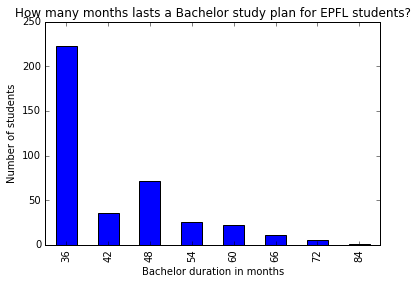

In [28]:
avg_duration_bachelor_degree = student_bachelor_done.groupby(['Durée bachelor (mois)']).count()['Nom Prénom'].plot(kind='bar')
avg_duration_bachelor_degree.set_ylabel('Number of students')
avg_duration_bachelor_degree.set_xlabel('Bachelor duration in months')
avg_duration_bachelor_degree.set_title('How many months lasts a Bachelor study plan for EPFL students?')

Before computing the average by sex, we check if the values in the 'Civilité' colmun are correct:

In [29]:
student_bachelor_done['Civilité'].value_counts()

Monsieur    368
Madame       29
Name: Civilité, dtype: int64

No outliers are present here and we can safely use the attribute to compute the mean.

In [30]:
student_bachelor_by_sex = student_bachelor_done[['Civilité', 'Durée bachelor (mois)']].groupby(['Civilité'])
student_bachelor_by_sex.mean()

,Durée bachelor (mois)
Civilité,
Madame,40.758621
Monsieur,42.880435


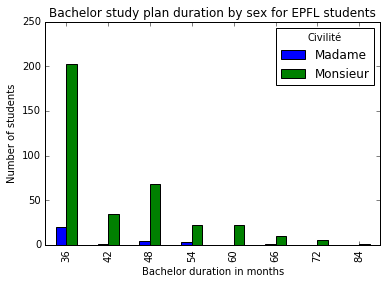

In [31]:
avg_duration_bachelor_degree_by_sex = student_bachelor_done.groupby(['Civilité', 'Durée bachelor (mois)']).count()['Nom Prénom'].unstack(level=0).fillna(0).plot(kind='bar')
avg_duration_bachelor_degree_by_sex.set_ylabel('Number of students')
avg_duration_bachelor_degree_by_sex.set_xlabel('Bachelor duration in months')
avg_duration_bachelor_degree_by_sex.set_title('Bachelor study plan duration by sex for EPFL students')
avg_duration_bachelor_degree_by_sex

It seems that female students obtain their bachelor degree in less months than male students in average. But as we know, average is not a robust statistic. Let's compute the median to have a better overview:

In [32]:
student_bachelor_by_sex.median()

,Durée bachelor (mois)
Civilité,
Madame,36
Monsieur,36


As the median is a robust statistic and as we don't see differences here, the initial hypothesis that we made ('there is probably a notable difference in results between female and male students') is not correct.

We can confirm this by making a T-Test to get the P-Value. As the number of female and male students is sufficiant (N > 20, N number of students, in the two cases) and as the durations of Bachelor study plan are independent between students, we can approximate the data with a normal distribution.

We need to test the hypothesis that female students success in less months than male students. The null hypothesis (H0 or null hypothesis) is that the duration of a Bachelor study plan for female and male students is the same.

Let's compute the P-value using the T-test:

In [33]:
boy_serie_duration_bachelor = student_bachelor_done['Durée bachelor (mois)'][[sex == 'Monsieur' for sex in student_bachelor_done['Civilité']]]
girl_serie_duration_bachelor = student_bachelor_done['Durée bachelor (mois)'][[sex == 'Madame' for sex in student_bachelor_done['Civilité']]]

stats.ttest_ind(a=boy_serie_duration_bachelor.values, b=girl_serie_duration_bachelor.values, equal_var=False)

Ttest_indResult(statistic=1.3437005678090845, pvalue=0.18785555340784144)

The P-Value is greater than the accepted value (0.37 > 0.05), so we can't reject our null hypothesis that female students and male students duration to obtain bachelor degree average is the same.

We can do the same check without doing any assumptions on data by using the K-S Test:

In [34]:
stats.ks_2samp(boy_serie_duration_bachelor.values, girl_serie_duration_bachelor.values)

Ks_2sampResult(statistic=0.1380247376311845, pvalue=0.65225950107177355)

Here, the null hypothesis is that the two samples are from the same distribution.

As P-value is high (>> 5%), we can't reject the null hypothesis, like in the T-Test above.

In conclusion, we can't validate our hypothesis that female students have an average duration to obtain the bachelor degree inferior to male students.

### Concluding with a brief note

In [35]:
len(student_bachelor_done)

397

As we said before, we only consider the students who started their study at EPFL. Thus, we only obtain 322 students at the end, while for 'Bachelor semestre 6', we had 500+ entries.

# Question 2 - Master

<b>Perform a similar operation to what described above, this time for Master students. Notice that this data is more tricky, as there are many missing records in the IS-Academia database. Therefore, try to guess how much time a master student spent at EPFL by at least checking the distance in months between Master semestre 1 and Master semestre 2. If the Mineur field is not empty, the student should also appear registered in Master semestre 3. Last but not the least, don't forget to check if the student has an entry also in the Projet Master tables. Once you can handle well this data, compute the "average stay at EPFL" for master students. Now extract all the students with a Spécialisation and compute the "average stay" per each category of that attribute -- compared to the general average, can you find any specialization for which the difference in average is statistically significant?</b>

We have already fetched the data from IS-Academia in the first question so, instead of fetching again data, we will simply get data from files created with pickle. We apply the same process used for Bachelor section, but this time we consider that a Master student can finish his master in different ways. Here are the new assumptions:

 - 6) all students start with the 'Master semestre 1' or 'Master semestre 2' but need to do both;
 - 7) a student can finish with only 'Master semestre 1' and 'Master semestre 2' without doing 'Master semestre 3' if there isn't a 'Mineur' value for 'Master semestre 2';
 - 8) a student can finish with 'Master semestre 1' and 'Master semestre 3' in case of missing data for 'Master semestre 2';
 - 9) a student can finish with an optional master projet in fall or spring but still need to be registered in 'Master semestre 1'.
 
**Note: As said in the beginning of this Notebook, we are not EPFL students and, thus, we don't know the exact rules of school. These assumptions can differ a bit from the functioning here at EPFL, but we tried to remain realistic regarding the obtained data.**
 
Let's fetch all data from files correspond to the semesters 1, 2, 3 or to fall/spring project sessions. At the same time, let's add the beginning date of every semester (like it was done in Q1 about Bachelor students):

In [36]:
master_semester_codes = {}
for section_name in semester_codes:
    if section_name.startswith('Projet Master') or (section_name.startswith('Master semestre') and section_name.endswith(tuple(['1', '2', '3']))):
        master_semester_codes[section_name] = semester_codes[section_name]

def master_append_year(data_per_year, semester_name, year_name):
    '''
    This function sets the exact beginning date of a given semester.
    Convention: For semester 2 and spring project session, beginning date is 02/01. Else, it is 08/01.
    '''
    if semester_name.endswith('2') or semester_name.endswith('printemps'):
        begin_date = year_name.split('-')[1] + '-02-01'
    else:
        begin_date = year_name.split('-')[0] + '-08-01'
    data_per_year[semester_name] = pd.to_datetime(begin_date)

master_dataframes = retrieve_dataframes(master_semester_codes, master_append_year)

Compute for Master semestre 2
Compute for Master semestre 1
Compute for Projet Master printemps
Compute for Master semestre 3
Compute for Projet Master automne


### Cleaning data

We also need to clean data like for Bachelor. We will make the Sciper number be the index and then remove duplicate rows after having sorted data by date of semester (ascending for semester 1 and descending in other cases):

In [37]:
master_data_semester1 = master_dataframes['Master semestre 1'].copy()
master_data_semester2 = master_dataframes['Master semestre 2'].copy()
master_data_semester3 = master_dataframes['Master semestre 3'].copy()
master_data_semester_fall_project = master_dataframes['Projet Master automne'].copy()
master_data_semester_spring_project = master_dataframes['Projet Master printemps'].copy()

master_data_semester1.sort_values('Master semestre 1', ascending=True, inplace=True)
master_data_semester1.drop_duplicates(subset='No Sciper', keep='first', inplace=True)
master_data_semester1.set_index('No Sciper', inplace=True)

master_data_semester2.sort_values('Master semestre 2', ascending=False, inplace=True)
master_data_semester2.drop_duplicates(subset='No Sciper', keep='first', inplace=True)
master_data_semester2.set_index('No Sciper', inplace=True)

master_data_semester3.sort_values('Master semestre 3', ascending=False, inplace=True)
master_data_semester3.drop_duplicates(subset='No Sciper', keep='first', inplace=True)
master_data_semester3.set_index('No Sciper', inplace=True)

master_data_semester_fall_project.sort_values('Projet Master automne', ascending=False, inplace=True)
master_data_semester_fall_project.drop_duplicates(subset='No Sciper', keep='first', inplace=True)
master_data_semester_fall_project.set_index('No Sciper', inplace=True)

master_data_semester_spring_project.sort_values('Projet Master printemps', ascending=False, inplace=True)
master_data_semester_spring_project.drop_duplicates(subset='No Sciper', keep='first', inplace=True)
master_data_semester_spring_project.set_index('No Sciper', inplace=True)

For students in 'Master semestre 2', we need to keep only those without 'Mineur' values because there are, then, also registered in 'Master semestre 3' (except students who are not registered for the next year, but those ones will be automatically removed during the final merge).

In [38]:
master_data_semester2_without_mineur = master_data_semester2[[len(mineur) == 0 for mineur in master_data_semester2['Mineur']]]

### Merging and concatenating data

Now we need to make one DataFrame for each assumption (assumptions 7, 8 and 9). To do so, we will make the needed attributes be the indexes (name, sex, beginning date of the semester and Sciper number) to prevent any drop of data when we will concatenate the 3 obtained DataFrames.

In [39]:
master_semester_1_2 = pd.merge(
    master_data_semester1[['Civilité', 'Nom Prénom', 'Spécialisation', 'Master semestre 1']],
    master_data_semester2_without_mineur[['Master semestre 2']],
    left_index=True,
    right_index=True,
    how='inner'
)
master_semester_1_2.reset_index(inplace=True)
master_semester_1_2.set_index(['No Sciper', 'Civilité', 'Nom Prénom', 'Spécialisation', 'Master semestre 1'], inplace=True)

master_semester_1_3 = pd.merge(
    master_data_semester1[['Civilité', 'Nom Prénom', 'Spécialisation', 'Master semestre 1']],
    master_data_semester3[['Master semestre 3']],
    left_index=True,
    right_index=True,
    how='inner'
)
master_semester_1_3.reset_index(inplace=True)
master_semester_1_3.set_index(['No Sciper', 'Civilité', 'Nom Prénom', 'Spécialisation', 'Master semestre 1'], inplace=True)

master_semester_1_pf = pd.merge(
    master_data_semester1[['Civilité', 'Nom Prénom', 'Spécialisation', 'Master semestre 1']],
    master_data_semester_fall_project[['Projet Master automne']],
    left_index=True,
    right_index=True,
    how='inner'
)
master_semester_1_pf.reset_index(inplace=True)
master_semester_1_pf.set_index(['No Sciper', 'Civilité', 'Nom Prénom', 'Spécialisation', 'Master semestre 1'], inplace=True)

master_semester_1_ps = pd.merge(
    master_data_semester1[['Civilité', 'Nom Prénom', 'Spécialisation', 'Master semestre 1']],
    master_data_semester_spring_project[['Projet Master printemps']],
    left_index=True,
    right_index=True,
    how='inner'
)
master_semester_1_ps.reset_index(inplace=True)
master_semester_1_ps.set_index(['No Sciper', 'Civilité', 'Nom Prénom', 'Spécialisation', 'Master semestre 1'], inplace=True)

Now we can concatenate DataFrames in a single one and try to make only the Sciper number being the index:

In [40]:
master_full_data = pd.concat([
        master_semester_1_2[['Master semestre 2']],
        master_semester_1_3[['Master semestre 3']],
        master_semester_1_pf[['Projet Master automne']],
        master_semester_1_ps[['Projet Master printemps']]
    ], axis=1)

In [41]:
# Check if the No Sciper is still unique
master_full_data.index.levels[0].is_unique

True

In [42]:
master_full_data.reset_index(inplace=True)
master_full_data.set_index(['No Sciper'], inplace=True)

master_full_data.head()

,Civilité,Nom Prénom,Spécialisation,Master semestre 1,Master semestre 2,Master semestre 3,Projet Master automne,Projet Master printemps
No Sciper,,,,,,,,
146330,Monsieur,Cardinaux Damien,,2007-08-01,2008-02-01,2008-08-01,NaT,NaT
146742,Monsieur,Marx Clément,"Signals, Images and Interfaces",2008-08-01,2010-02-01,2012-08-01,2010-08-01,2011-02-01
146929,Monsieur,Junod Antoine,,2007-08-01,2008-02-01,NaT,NaT,NaT
147008,Monsieur,Good Xavier,"Signals, Images and Interfaces",2011-08-01,2013-02-01,2012-08-01,NaT,NaT
152232,Monsieur,Anagnostaras David,,2007-08-01,NaT,2008-08-01,NaT,NaT


We can see that the student associated to the Sciper number '152232' is concerned by the assumption 8 as he hasn't data for 'Master semestre 2'. We decided to keep this kind of entries because there are a lot:

In [43]:
master_full_data[master_full_data['Master semestre 2'].isnull()]

,Civilité,Nom Prénom,Spécialisation,Master semestre 1,Master semestre 2,Master semestre 3,Projet Master automne,Projet Master printemps
No Sciper,,,,,,,,
152232,Monsieur,Anagnostaras David,,2007-08-01,NaT,2008-08-01,NaT,NaT
167045,Monsieur,Tangui Achraf,,2008-08-01,NaT,2010-08-01,NaT,NaT
170220,Monsieur,Barras Florian,,2009-08-01,NaT,2011-08-01,NaT,NaT
170225,Monsieur,Burgener Raphaël,,2009-08-01,NaT,2010-08-01,NaT,NaT
170451,Monsieur,Bolkensteyn Dinesh,,2008-08-01,NaT,2010-08-01,NaT,NaT
171073,Monsieur,Jiekak Ndeutou Stève Aurélien,Internet computing,2009-08-01,NaT,2010-08-01,NaT,NaT
174774,Monsieur,Balas Martin,,2010-08-01,NaT,2011-08-01,NaT,NaT
174905,Monsieur,Aubelle Flavien,,2012-08-01,NaT,2013-08-01,NaT,NaT
176564,Monsieur,Helfer Jonas,,2009-08-01,NaT,2010-08-01,NaT,NaT


Now we can compute the number of months by comparing the date in 'Master semestre 1' with the latest date between semester 2 or 3 or projects:

In [44]:
# We need to find the latest and earliest dates between semester 1, 2, 3 or projects
# because some students start their Master by doing the semester 2 before the semester 1
def latest_date(dates):
    '''
    This function returns the latest date between a set of valid dates.
    '''
    return max(dates[[not pd.isnull(date) for date in dates]])

def earliest_date(dates):
    '''
    This function returns the earliest date between a set of valid dates.
    '''
    return min(dates[[not pd.isnull(date) for date in dates]])

def compute_nb_months_master(row):
    '''
    This functions computes the number of months a Master lasts, comparing the earliest and latest dates
    corresponding to the aforesaid Master.
    '''
    latest = latest_date(row[['Master semestre 1', 'Master semestre 2', 'Master semestre 3', 'Projet Master automne', 'Projet Master printemps']])
    earliest = earliest_date(row[['Master semestre 1', 'Master semestre 2']])
    delta = relativedelta.relativedelta(latest, earliest) 
    return delta.years * 12 + delta.months + 6

# Again, we use French here to comply with data fetched from IS-Academia
master_full_data['Durée master (mois)'] = master_full_data.apply(compute_nb_months_master, axis=1)

master_full_data.head()

,Civilité,Nom Prénom,Spécialisation,Master semestre 1,Master semestre 2,Master semestre 3,Projet Master automne,Projet Master printemps,Durée master (mois)
No Sciper,,,,,,,,,
146330,Monsieur,Cardinaux Damien,,2007-08-01,2008-02-01,2008-08-01,NaT,NaT,18
146742,Monsieur,Marx Clément,"Signals, Images and Interfaces",2008-08-01,2010-02-01,2012-08-01,2010-08-01,2011-02-01,54
146929,Monsieur,Junod Antoine,,2007-08-01,2008-02-01,NaT,NaT,NaT,12
147008,Monsieur,Good Xavier,"Signals, Images and Interfaces",2011-08-01,2013-02-01,2012-08-01,NaT,NaT,24
152232,Monsieur,Anagnostaras David,,2007-08-01,NaT,2008-08-01,NaT,NaT,18


### Using statistics

We can, firstly, compute the average duration (in months) for a Computer Science (CS) Master at EPFL.

In [45]:
master_full_data['Durée master (mois)'].mean()

19.871559633027523

We can also focus on available specialisations for CS Masters.

In [46]:
nb_students_by_specialisation = master_full_data.groupby(['Spécialisation']).agg({'Durée master (mois)':{'Nombre d\'étudiants':'count'}})
nb_students_by_specialisation.columns = nb_students_by_specialisation.columns.droplevel(0)
nb_students_by_specialisation

,Nombre d'étudiants
Spécialisation,
,691
Biocomputing,1
Computer Engineering - SP,4
Data Analytics,2
Foundations of Software,16
Information Security - SP,1
Internet computing,25
Service science,2
"Signals, Images and Interfaces",15


We see, for example, that the majority of students don't choose any specialisation during their Master course.

Let's compute the mean of months duration of a CS Master at EPFL.

In [47]:
mean_cs_duration_by_spycialisation = master_full_data.groupby(['Spécialisation']).agg({'Durée master (mois)':{'Durée moyenne d\'un Master (mois)':'mean'}})
mean_cs_duration_by_spycialisation.columns = mean_cs_duration_by_spycialisation.columns.droplevel(0)
mean_cs_duration_by_spycialisation

,Durée moyenne d'un Master (mois)
Spécialisation,
,19.615051
Biocomputing,18.000000
Computer Engineering - SP,21.000000
Data Analytics,15.000000
Foundations of Software,22.125000
Information Security - SP,30.000000
Internet computing,21.600000
Service science,18.000000
"Signals, Images and Interfaces",25.200000


We see that there is some gap between results.

However, and as we said before, average is not a robust statistic. Let's check what we obtain using the median here.

In [48]:
median_cs_duration_by_spycialisation = master_full_data.groupby(['Spécialisation']).agg({'Durée master (mois)':{'Durée médiane d\'un Master (mois)':'median'}})
median_cs_duration_by_spycialisation.columns = median_cs_duration_by_spycialisation.columns.droplevel(0)
median_cs_duration_by_spycialisation

,Durée médiane d'un Master (mois)
Spécialisation,
,18
Biocomputing,18
Computer Engineering - SP,21
Data Analytics,15
Foundations of Software,21
Information Security - SP,30
Internet computing,24
Service science,18
"Signals, Images and Interfaces",24


Differences are still important, so we have to focus our attention on the obtained results and do other checks.

Here the T-test is not appropriate ; indeed, the number of students with a 'Spécialisation' is not big enough to be approximated by a normal distibution. Moreover, we don't have any information about the distibution of the data we are analysing.

However, the K-S test seems appropriate for 'Spécialisation' greater in which there are at least 5 people (in order to compare distribution with enough value).

> We removed 'Computer Engineering - SP', 'Data Analytics', 'Information Security - SP' and 'Service science' from our study because of the number of students in (< 5).

The test will tell us if 'Spécialisation' criterion is statiscally close to the data related to Master students.

In [49]:
global_duration_serie = master_full_data['Durée master (mois)'].values
specialities_duration_series = {}

for speciality in master_full_data['Spécialisation'].unique():
    speciality_name = speciality if len(speciality) > 0 else '<No specialisation>'
    specialities_duration_series[speciality_name] = master_full_data['Durée master (mois)'][[spe == speciality for spe in master_full_data['Spécialisation']]].values

print('*** K-S test results ***\n')
for speciality_name, speciality_serie in specialities_duration_series.items():
    print(speciality_name + ':\n\t', end='')
    print(stats.ks_2samp(global_duration_serie, speciality_serie), end='\n\n')

*** K-S test results ***

Internet computing:
	Ks_2sampResult(statistic=0.20152031454783748, pvalue=0.24899599766308464)

Foundations of Software:
	Ks_2sampResult(statistic=0.18152031454783746, pvalue=0.63489452292285387)

Data Analytics:
	Ks_2sampResult(statistic=0.31847968545216254, pvalue=0.95513987659961386)

Computer Engineering - SP:
	Ks_2sampResult(statistic=0.19659239842726081, pvalue=0.99331894889568428)

Service science:
	Ks_2sampResult(statistic=0.31847968545216254, pvalue=0.95513987659961386)

Biocomputing:
	Ks_2sampResult(statistic=0.31847968545216254, pvalue=0.99795151925956882)

Software Systems:
	Ks_2sampResult(statistic=0.19659239842726081, pvalue=0.95565723658428914)

Information Security - SP:
	Ks_2sampResult(statistic=0.84534731323722145, pvalue=0.23024482456234563)

<No specialisation>:
	Ks_2sampResult(statistic=0.020361016855925174, pvalue=0.99804936910271569)

Signals, Images and Interfaces:
	Ks_2sampResult(statistic=0.34818698121450414, pvalue=0.0426101395603813

*Note: Here, global duration was used for each K-S test.*

The null-hypothesis for the K-S test is that the distributions are the same. Thus, the lower the P-value the greater the statistical evidence is to reject the null hypothesis and conclude that the distributions are different.

If we take P-Value < 5%, we can only reject the null-hypothesis for the 'Signals, Images and Interfaces'.

With the data we have, we can only say that students in speciality 'Signals, Images and Interfaces' spend more time than in general to obtain the master degree.

# Bonus

**Perform the gender-based study also on the Master students, as explained in 1. Use scatterplots to visually identify changes over time. Plot males and females with different colors -- can you spot different trends that match the results of your statistical tests?**

First, let's plot a graph showing the duration of CS Master course according to the sex for EPFL students.

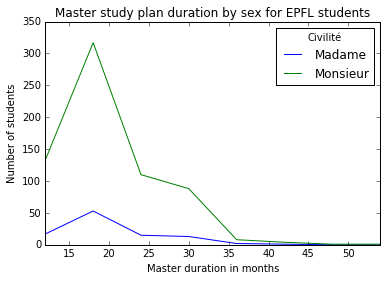

In [50]:
avg_duration_master_degree_by_sex = master_full_data.groupby(['Civilité', 'Durée master (mois)']).count()['Nom Prénom'].unstack(level=0).fillna(0).plot()
avg_duration_master_degree_by_sex.set_ylabel('Number of students')
avg_duration_master_degree_by_sex.set_xlabel('Master duration in months')
avg_duration_master_degree_by_sex.set_title('Master study plan duration by sex for EPFL students')
avg_duration_master_degree_by_sex

The graph tends to show that for female and male students, the behavior is the same (especially, a majority of students obtain their Master in 18 months).

However, we must keep in mind that the number of male students is really higher than the number of female students, and thus, making conclusion regarding any link between the two sets must be dangerous without further analysis.

As proposed, we can display the evolution of the mean duration for Master degree over the year.

*Notes : Here, we assume by convention that a student is considered when he registers for a Master course. For example, if a student X starts a Master course in 2010 and graduates in 2012, after 18 months, he will be counted for 2010 and his associated duration will be 18. Also, for 2016, it seems that there is no available data for female students in CS...*

In [51]:
def get_beginning_year_master(row):
    '''
    This functions retrieves the year of registration to a Master course for a given student.
    '''
    earliest = earliest_date(row[['Master semestre 1', 'Master semestre 2']])
    return earliest.year

all_master_data = master_full_data.copy()

# We add the beginning year for each student in a new column
all_master_data['Année de début de Master'] = all_master_data.apply(get_beginning_year_master, axis=1)

# These properties are used for the plot
properties = {'Madame': {'label':'Female', 'color': 'red', 'marker':'x'},
              'Monsieur': {'label':'Male', 'color': 'blue', 'marker':'o'}}

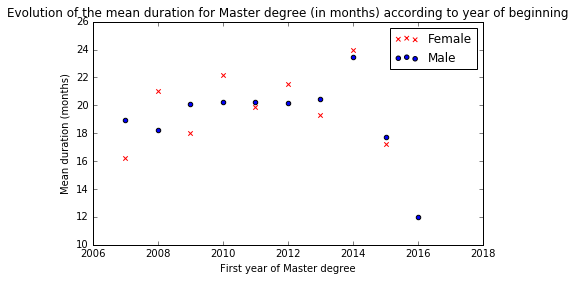

In [52]:
# We create a plot and set its size
f, axes = plt.subplots(figsize=(7,4))

# For each category (Female, Male), we plot the corresponding graph (we use mean here)
for label, df in all_master_data.groupby(['Civilité', 'Année de début de Master']).mean().reset_index().groupby('Civilité'):
    df.plot(kind='scatter', x='Année de début de Master', y='Durée master (mois)', ax=axes, label=properties[label]['label'], color=properties[label]['color'], marker=properties[label]['marker'])

# Finally, we add the title and labels    
axes.set_title('Evolution of the mean duration for Master degree (in months) according to year of beginning')
axes.set_xlabel('First year of Master degree')
axes.set_ylabel('Mean duration (months)')

We can notice some differences over some years, but it is difficult here to conclude anything.

Let's plot the same graph but using the median, which is a robust statistic.

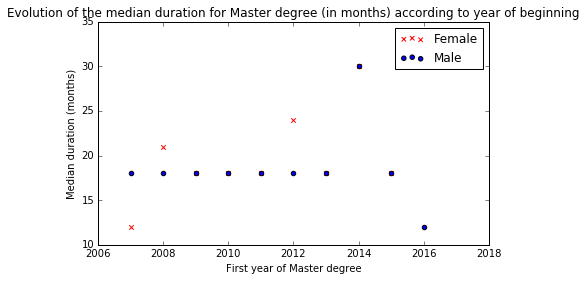

In [53]:
# We create a plot and set its size
f, axes = plt.subplots(figsize=(7,4))

# For each category (Female, Male), we plot the corresponding graph (we use median here)
for label, df in all_master_data.groupby(['Civilité', 'Année de début de Master']).median().reset_index().groupby('Civilité'):
    df.plot(kind='scatter', x='Année de début de Master', y='Durée master (mois)', ax=axes, label=properties[label]['label'], color=properties[label]['color'], marker=properties[label]['marker'])

# Finally, we add the title and labels    
axes.set_title('Evolution of the median duration for Master degree (in months) according to year of beginning')
axes.set_xlabel('First year of Master degree')
axes.set_ylabel('Median duration (months)')

Here, we see that over the years, the duration between female and male students is approximately the same (except for 2008 and 2012), and thus, we cannot make any assumption.

In [54]:
female_students_master = master_full_data['Durée master (mois)'][[sex == 'Madame' for sex in master_full_data['Civilité']]].values
male_students_master = master_full_data['Durée master (mois)'][[sex == 'Monsieur' for sex in master_full_data['Civilité']]].values
stats.ks_2samp(female_students_master, male_students_master)

Ks_2sampResult(statistic=0.032589512727707798, pvalue=0.99997956042436631)

Using K-S test, we see that the P-value is extremely high. Thus, we can't reject the null hypothesis and state that the two distributions are different, in general.

<b>Important note: In total, we have much more man students than female students so the K-S test must not be fully trusted here!</b>

The last thing we can do is checking year by year if we can assume a sufficient difference in order to conclude that the two distribution were different.

First, we have to compute the number of students for each year, and according to the sex, to ensure that we have enough values.

In [55]:
all_master_data.groupby(['Civilité', 'Année de début de Master']).count()

number_master_students_per_year = all_master_data.groupby(['Civilité', 'Année de début de Master']).agg({'Durée master (mois)':{'Nombre d\'étudiants':'count'}})
number_master_students_per_year.columns = number_master_students_per_year.columns.droplevel(0)
number_master_students_per_year

Nombre d'étudiants
Civilité Année de début de Master                    
Madame   2007                                      10
         2008                                       6
         2009                                       3
         2010                                      13
         2011                                      16
         2012                                      12
         2013                                      14
         2014                                      12
         2015                                      15
Monsieur 2007                                      59
         2008                                      48
         2009                                      43
         2010                                      79
         2011                                      76
         2012                                      71
         2013                                      79
         2014                                      86
         2015                                     111
         2016                                      10

For 2009, we have only 3 students, which is very low.

<b>Important note (bis): More generally, we have much more man students than female students for each year so the following K-S tests must not be fully trusted!</b>

In [56]:
print('*** K-S test results ***\n')
for year in all_master_data['Année de début de Master'].unique()[:-1]:
    duration_for_female = all_master_data['Durée master (mois)'][(all_master_data['Civilité'] == 'Madame') & (all_master_data['Année de début de Master'] == year)].values
    duration_for_male = all_master_data['Durée master (mois)'][(all_master_data['Civilité'] == 'Monsieur') & (all_master_data['Année de début de Master'] == year)].values
    print('%02d :\n\t' % year, end='')
    print(stats.ks_2samp(duration_for_female, duration_for_male), end='\n')

*** K-S test results ***

2007 :
	Ks_2sampResult(statistic=0.3627118644067796, pvalue=0.16425207020368532)
2008 :
	Ks_2sampResult(statistic=0.4375, pvalue=0.19079753088575546)
2011 :
	Ks_2sampResult(statistic=0.13486842105263158, pvalue=0.95676540890426909)
2009 :
	Ks_2sampResult(statistic=0.34883720930232553, pvalue=0.79364700503366725)
2010 :
	Ks_2sampResult(statistic=0.10321324245374874, pvalue=0.99947240267417436)
2014 :
	Ks_2sampResult(statistic=0.13178294573643412, pvalue=0.98804690249005545)
2012 :
	Ks_2sampResult(statistic=0.14671361502347419, pvalue=0.96842264235413555)
2013 :
	Ks_2sampResult(statistic=0.22423146473779376, pvalue=0.53225923682245657)
2015 :
	Ks_2sampResult(statistic=0.079279279279279274, pvalue=0.99999060841968357)


We can see that the distribution over the time is not identical because the P-Value change every year. But in every case, we can't reject the null-hypothesis (> 5%).